In [103]:
%%capture
!pip install gql requests sklearn wordcloud numpy pandas

In [104]:
import requests
from IPython.display import display, Markdown
from gql import gql, Client
from gql.transport.requests import RequestsHTTPTransport

_transport = RequestsHTTPTransport(
    url='https://api.datacite.org/graphql',
    use_json=True,
)


client = Client(
    transport=_transport,
    fetch_schema_from_transport=True,
)

In [207]:
# Generate the GraphQL query: find all outputs FREYA project (https://cordis.europa.eu/project/id/777523) to date
query_params = {
    "flatline_query" : "shakespeare",
    "long_term_fall_query" : "Machine learning",
    "sharp_growth_query" : "ebola",
    "max_dissertations" : 200
}

query = gql("""query getDissertationsByQuery(
    $flatline_query: String!,
    $long_term_fall_query: String!
    $sharp_growth_query: String!,
    $max_dissertations: Int!
    )
{
  flatline_query:  dissertations(query: $flatline_query, first: $max_dissertations) {
    totalCount
    years {
      count
      title
    }
    nodes {
      id
      titles {
        title
      }
      descriptions {
         description
      }      
      versionOfCount
      identifiers {
        identifier
      }
      publicationYear
      bibtex
      repository {
        id
      }
      publisher
      creators {
        id
        name
      }
    }
  },
  long_term_fall_query: dissertations(query: $long_term_fall_query, first: $max_dissertations) {
    totalCount
    years {
      count
      title
    }
    nodes {
      id
      titles {
        title
      }
      descriptions {
         description
      }
      versionOfCount
      identifiers {
        identifier
      }
      publicationYear
      bibtex
      repository {
        id
      }
      publisher
      creators {
        id
        name
      }
    }
  },
  sharp_growth_query: dissertations(query: $sharp_growth_query, first: $max_dissertations) {
    totalCount
    years {
      count
      title
    }
    nodes {
      id
      titles {
        title
      }
      descriptions {
         description
      }      
      versionOfCount
      bibtex
      identifiers {
        identifier
      }
      publicationYear
      repository {
        id
      }
      publisher
      creators {
        id
        name
      }
    }
  }
}
""")

In [208]:
import json
data = client.execute(query, variable_values=json.dumps(query_params))

In [209]:
# Get the total number of dissertations per category
for query in ['flatline_query', 'long_term_fall_query', 'sharp_growth_query']:
    print("The total number of dissertations for query %s:\n%s" % (query_params[query], str(data[query]['totalCount'])))

The total number of dissertations for query goethe:
84
The total number of dissertations for query Machine learning:
1693
The total number of dissertations for query ebola:
45


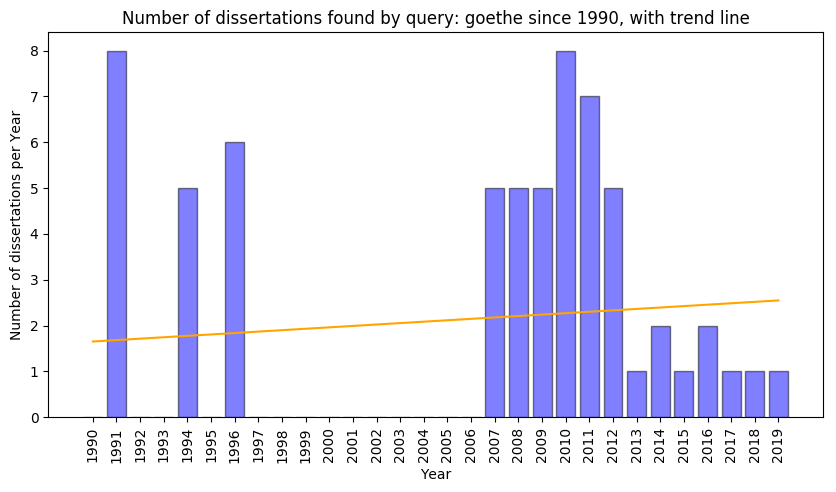

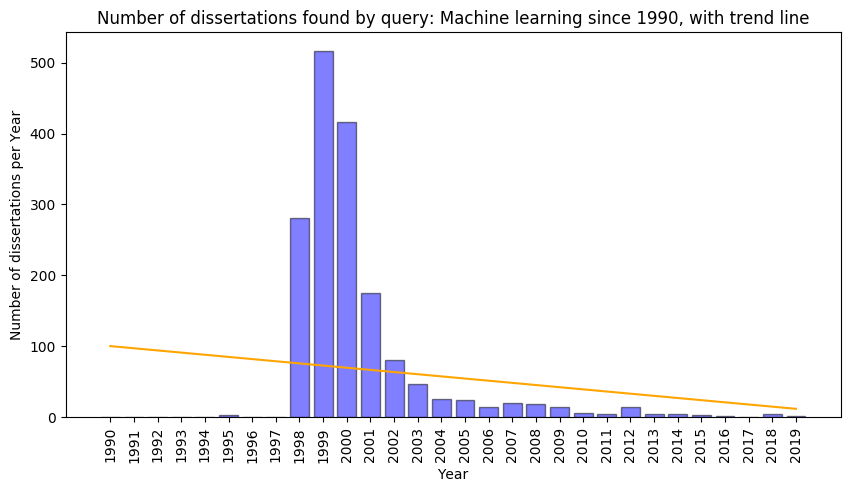

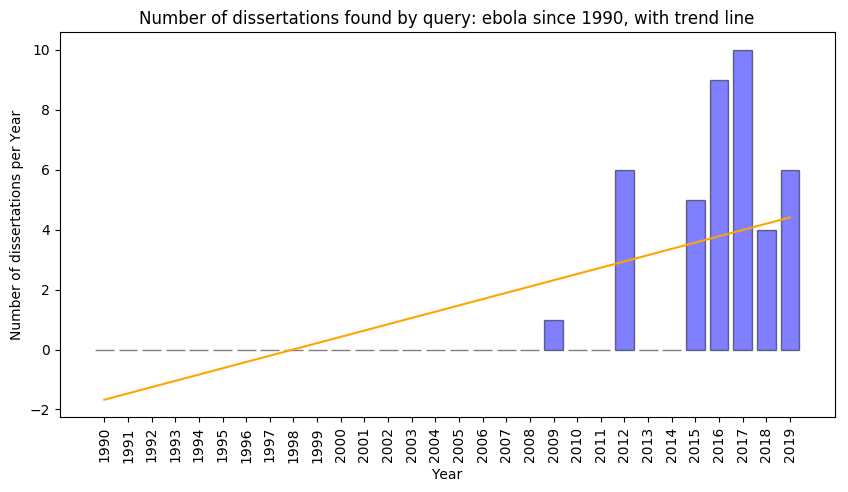

In [210]:
# Plot the total number of datasets to date, by year
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge

start_year = 1990
end_year = 2020
for query in ['flatline_query', 'long_term_fall_query', 'sharp_growth_query']:
    dissertations = data[query]
    queryName = query_params[query]
    plt.rcdefaults()
    sorted_years = sorted([int(s['title']) for s in dissertations['years']])
    num_outputs4sorted_years = [s['count'] for s in dissertations['years']]
    # Get a list of all consecutive years between min and max year (inclusive)
    all_years = list(range(start_year, end_year))
    # Populate output counts (into num_counts) for all consecutive years
    num_outputs = []
    for year in all_years:
        if year in sorted_years:
            idx = sorted_years.index(year)
            num_outputs.append(num_outputs4sorted_years[idx])
        else:
            num_outputs.append(0)     

    df = pd.DataFrame({'Year': all_years, 'Count': num_outputs} )
    # Create trend line for the plot     
    lr = Ridge()
    lr.fit(df[['Year']], df['Count'])

    fig, ax = plt.subplots(1, 1, figsize = (10, 5))
    ax.bar(df['Year'],  df['Count'], align='center', color='blue', edgecolor='black', linewidth=1, alpha=0.5)
    ax.set_xticks(df['Year'])
    ax.set_xticklabels(all_years, rotation='vertical')
    ax.set_ylabel('Number of dissertations per Year')
    ax.set_xlabel('Year')
    ax.set_title('Number of dissertations found by query: %s since %s, with trend line' % (query_params[query], str(start_year)))
    ax.plot(df['Year'], lr.coef_*df['Year']+lr.intercept_, color='orange')
    plt.show()


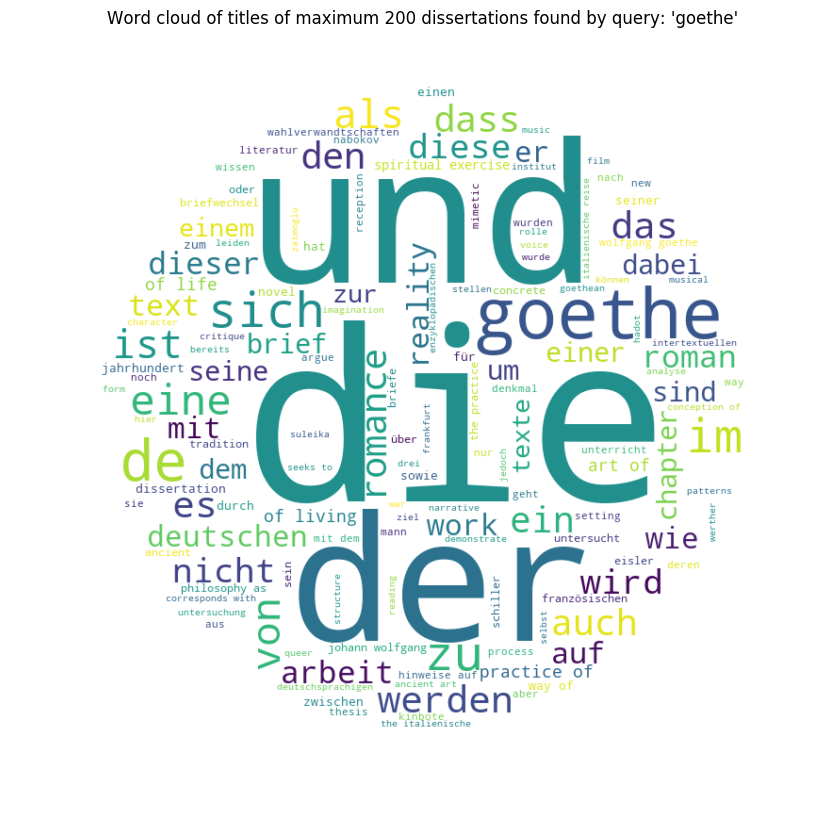

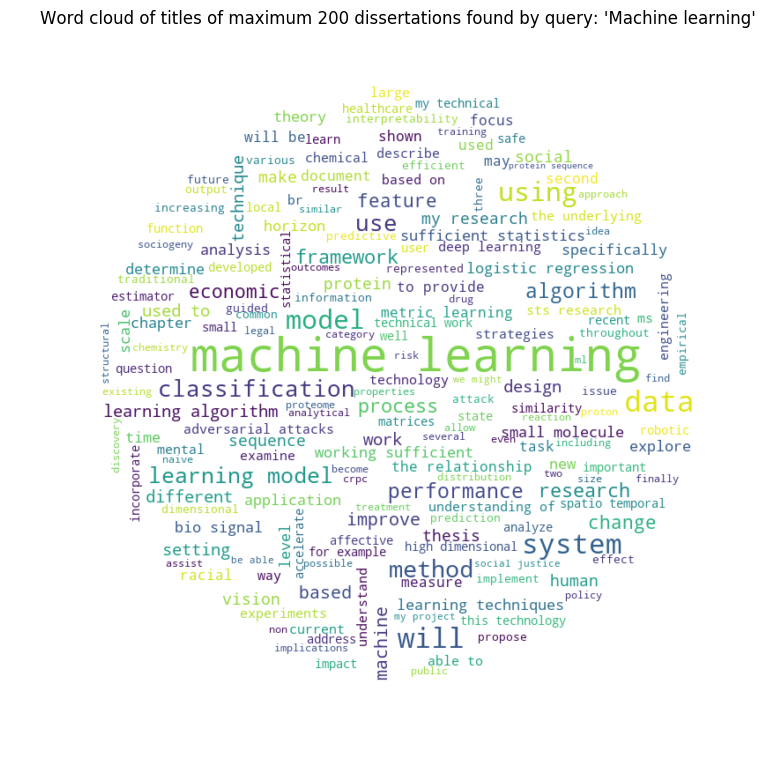

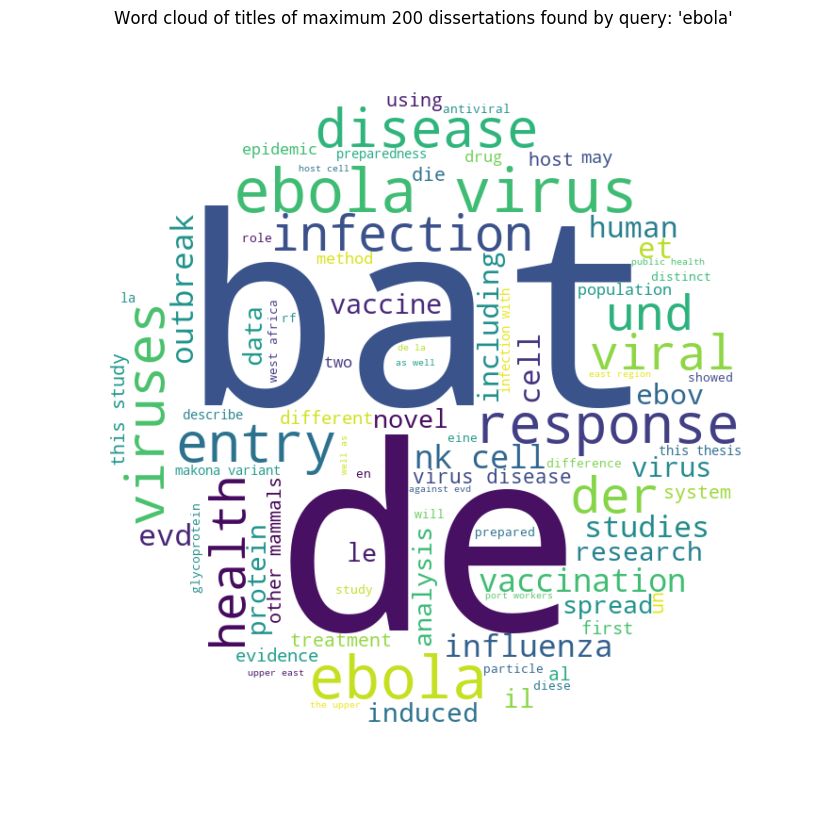

In [211]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd

stopWords = set(STOPWORDS)
stopWords.add('_')

for query in ['flatline_query', 'long_term_fall_query', 'sharp_growth_query']:
    titleWords=[]
    dissertations = data[query]
    for r in dissertations['nodes']:
        for title in r['titles']:
            tokens = [t.lower() for t in str(title['title']).split()] 
        for title in r['descriptions']:
            tokens = [t.lower() for t in str(title['description']).split()]     
        titleWords += tokens
     
    x, y = np.ogrid[:800, :800]
    mask = (x - 400) ** 2 + (y - 400) ** 2 > 345 ** 2
    mask = 255 * mask.astype(int)
    
    wordcloud = WordCloud(width = 600, height = 600, 
                background_color ='white', 
                stopwords = stopWords, 
                min_font_size = 10, 
                mask = mask).generate(" ".join(titleWords))
    
    fig, ax = plt.subplots(1, 1, figsize = (8, 8), facecolor = None)
    ax.set_title("Word cloud of titles of maximum %d dissertations found by query: '%s'" % (query_params['max_dissertations'],query_params[query]))
    plt.imshow(wordcloud, interpolation="bilinear") 
    plt.axis("off") 
    plt.tight_layout(pad = 0)
    plt.show()

        


In [137]:
import pandas as pd
from IPython.display import Javascript
from requests.utils import requote_uri

# For each repository, download a file of BibTeX entries in csv format
for query in ['flatline_query', 'long_term_fall_query', 'sharp_growth_query']:    
    dissertations = data[query]
    bibtex_data = []
    for r in dissertations['nodes']:
        bibtex_data.append([r['bibtex']])
    df = pd.DataFrame(bibtex_data, columns = None)

    js_download = """
var csv = '%s';

var filename = '%s.bib';
var blob = new Blob([csv], { type: 'application/x-bibtex;charset=utf-8;' });
if (navigator.msSaveBlob) { // IE 10+
    navigator.msSaveBlob(blob, filename);
} else {
    var link = document.createElement("a");
    if (link.download !== undefined) { // feature detection
        // Browsers that support HTML5 download attribute
        var url = URL.createObjectURL(blob);
        link.setAttribute("href", url);
        link.setAttribute("download", filename);
        link.style.visibility = 'hidden';
        document.body.appendChild(link);
        link.click();
        document.body.removeChild(link);
    }
}
""" % (df.to_csv(index=False, header=False).replace('\n','\\n').replace("\'","\\'").replace("\"",""), requote_uri(query_params[query]))
    
    display(Javascript(js_download))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>